In [1]:
import os
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Replication assignment

Replicate the results found in [Bryant et al  (2010)](https://doi.org/10.1016/j.techfore.2009.08.002), [Rozenberg et al (2014)](https://link.springer.com/content/pdf/10.1007/s10584-013-0904-3.pdf), and [Hamarat et al (2013)](https://doi.org/10.1016/j.techfore.2012.10.004). The data files are named accordingly. The full details for these papers can be found the course guide. Rozenberg et al and Hamarat et al are optional readings for this week. You can also look at [Kwakkel & Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092), which gives a succint summary of these three cases. 

An additional useful, if dated, resource for Bryant et al is https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/ 

mpld3 is no longer supported for python 3.6. Instead, use the `%matplotlib notebook` [magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib) for interaction with the trade-off curves. You can revert back to inline with `%matplotlib inline`


# Bryant & Lempert

*hint load the data using pandas, extract the experiments and outcomes from it. Cast the experiments to a numpy recarray*

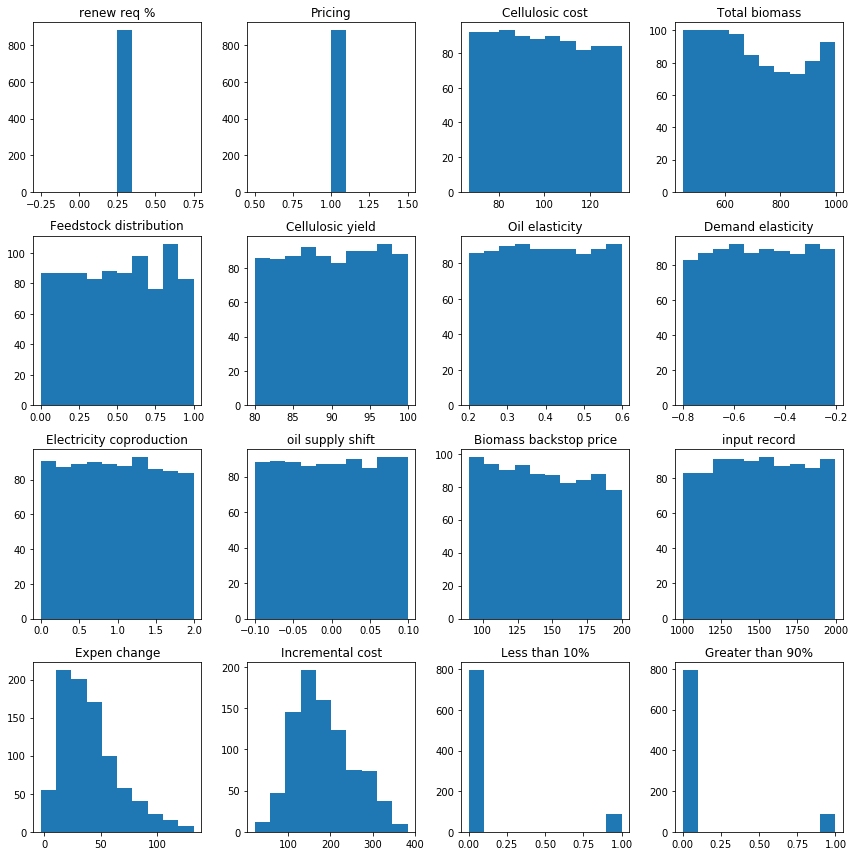

In [2]:
# Check how data consists of:
df = pd.read_csv("./data/Bryant et al 2010.csv")
# print(df.head())
plt.figure(figsize = (12,12))
i = 0
for col in df.columns:
    i += 1
    plt.subplot(4, 4, i)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout()

In [3]:
params = df.columns[2:11]
params

Index(['Cellulosic cost', 'Total biomass', 'Feedstock distribution',
       'Cellulosic yield', 'Oil elasticity', 'Demand elasticity',
       'Electricity coproduction', 'oil supply shift',
       'Biomass backstop price'],
      dtype='object')

Text(0.5,1,'Distribution of Outcomes \n(10% Boundary at "Expen change" = 77.98)')

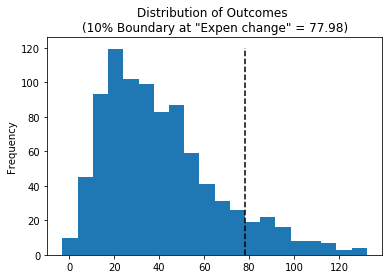

In [4]:
# what is the boundary between "desirable" and "undesirable"
fig, ax = plt.subplots()
q = df["Expen change"].quantile(q=0.90)
q = np.round(q,2)
df["Expen change"].plot(kind="hist", ax = ax, bins = 20)
ax.vlines(x=q,ymin=0,ymax=120,linestyle="--")
ax.set_title('Distribution of Outcomes \n(10% Boundary at "Expen change" = {q})'.format(q=q))

In [5]:
print(df[df["Expen change"] > q]["Greater than 90%"].unique())
print(df[df["Expen change"] >= q]["Less than 10%"].unique())
# all rows are labeld in correct way!

[1]
[0]


### Depending on parameters, See how Desirable and Undesirable Outcomes are generated

Text(0.5,1.02,'Differences (from Input Parameters) which make Outcome Different')

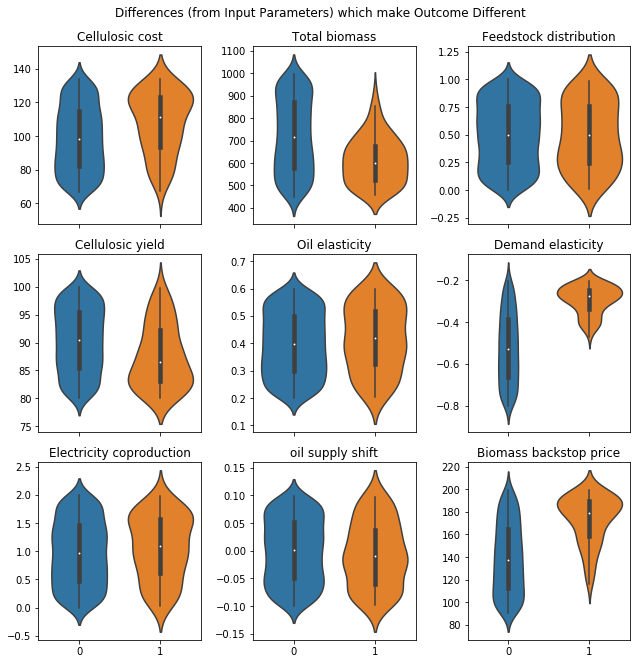

In [6]:
ncols=3
nrows=3
fig, axes = plt.subplots(ncols = ncols, nrows = nrows,
                         sharex = True,
                         figsize = (9,9))
locs = list(itertools.product(range(nrows),range(ncols)))

for i,param in enumerate(params):
    loc=locs[i]
    ax=axes[loc]
    sns.violinplot("Greater than 90%", param, data = df, ax=ax, legend=True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(param)
fig.tight_layout()
fig.suptitle("Differences (from Input Parameters) which make Outcome Different", y=1.02)

### Interpretation:
    what makes different outcome? (0:Desirable or 1: Undesirable)
    → Estimated Importance Rank (Visually)
    1. 'Demand elasticity'
    2. 'Biomass backstop price'
    3. 'Total biomass'
    4. 'Cellulosic cost'
    
    Other inputs: Doesn't seem to be so important

Some Clusters are observed!


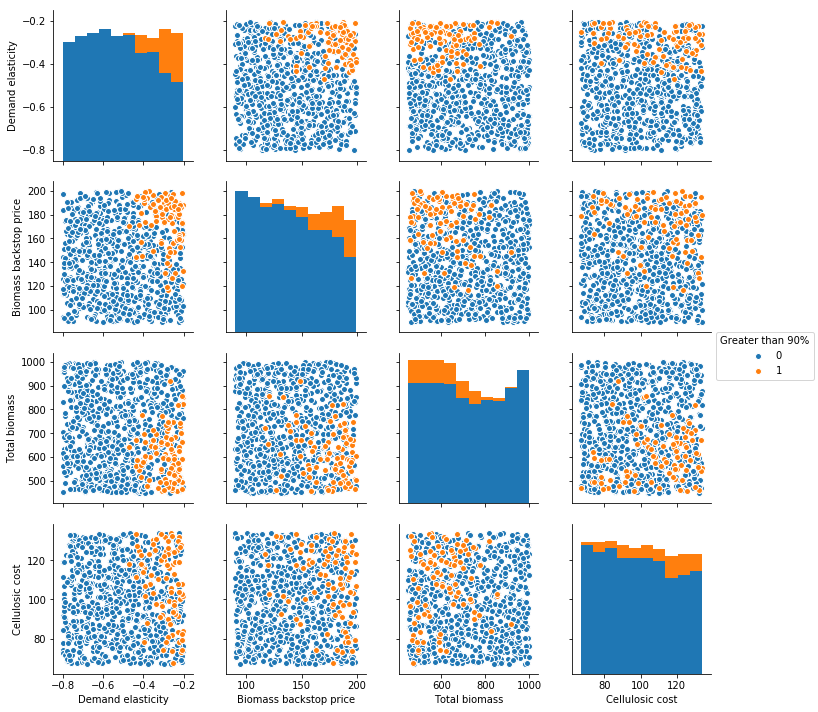

In [7]:
import_params = ['Demand elasticity', 'Biomass backstop price', 'Total biomass', 'Cellulosic cost']
sns.pairplot(df, hue="Greater than 90%", vars = import_params)
print("Some Clusters are observed!")

In [8]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Anaconda3\envs\py36_32\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

In [9]:
x = df[params].to_records()
y = df["Greater than 90%"].values

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] 882 points remaining, containing 89 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05102040816326531, coverage: 0.5056179775280899, density: 1.0 restricted_dimensions: 6


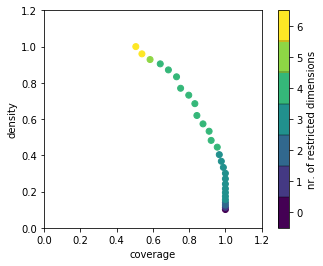

In [10]:
box1.show_tradeoff()
plt.show()

In [11]:
box1.inspect(i = 20, style='table')

coverage    0.797753
density     0.731959
mass        0.109977
mean        0.731959
res dim            4
Name: 20, dtype: object

                            box 20                                      
                               min         max                 qp values
Demand elasticity        -0.422000   -0.202000   [7.079941163959903e-19]
Biomass backstop price  138.599998  199.600006   [5.228199370673111e-10]
Total biomass           450.000000  755.799988  [1.0998160915512434e-06]
Cellulosic cost          72.650002  133.699997     [0.10301317448152089]



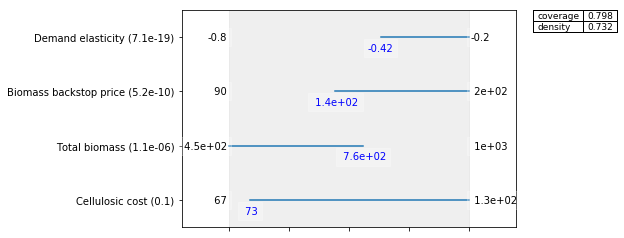

In [12]:
box1.inspect(i = 20, style='graph')
plt.show()

# Rozenberg et al

there are several issues with this case
* apply prim separately for each SSP
* you have to play with the threshold for each SSP, the default of 0.8 is too high in several cases
* if you look at the paper carefully, you will discover that they change some of the default parameters of PRIM


# Hamarat et al

this is the most difficult dataset to analyze with prim. As can be seen by the results, PRIM fails to find a good explanation for why negative outcomes occur. 
